In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizer

c:\Users\andrian21\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('processed_train_df.csv')
train_df = train_df[['Entity', 'en_content', 'Sentiment']]
train_df.columns = ['Entity', 'Content', 'Sentiment']
train_df

,Entity,Content,Sentiment
0,Borderlands,"['i', 'be', 'come', 'to', 'the', 'border', 'an...",Positive
1,Borderlands,"['i', 'be', 'get', 'on', 'borderland', 'and', ...",Positive
2,Borderlands,"['i', 'be', 'come', 'on', 'borderland', 'and',...",Positive
3,Borderlands,"['i', 'be', 'get', 'on', 'borderland', '2', 'a...",Positive
4,Borderlands,"['i', 'be', 'get', 'into', 'borderland', 'and'...",Positive
...,...,...,...
51468,Nvidia,"['my', 'be', 'no', 'highlight', 'picture', 're...",Positive
51469,Nvidia,"['just', 'realize', 'that', 'my', 'mac', 'wind...",Positive
51470,Nvidia,"['just', 'realize', 'the', 'window', 'partitio...",Positive
51471,Nvidia,"['just', 'realize', 'between', 'the', 'window'...",Positive


In [3]:
test_df = pd.read_csv('processed_test_df.csv')
test_df = test_df[['Entity', 'en_content', 'Sentiment']]
test_df.columns = ['Entity', 'Content', 'Sentiment']
test_df

,Entity,Content,Sentiment
0,Amazon,"['broadcasting', 'corporation', 'news', 'amazo...",Neutral
1,Microsoft,"['why', 'do', 'i', 'pay', 'for', 'word', 'when...",Negative
2,CS-GO,"['matchmaking', 'be', 'so', 'full', 'of', 'clo...",Negative
3,Google,"['now', 'the', 'president', 'be', 'slap', 'in'...",Neutral
4,FIFA,"['hi', 'i', 'have', 'in', 'my', 'cellar', 'for...",Negative
...,...,...,...
994,GrandTheftAuto(GTA),"['be', 'the', 'art', 'and', 'culture', 'capita...",Irrelevant
995,CS-GO,"['this', 'be', 'actually', 'a', 'good', 'move'...",Irrelevant
996,Borderlands,"['today', 'suck', 'so', 'it', 's', 'time', 'to...",Positive
997,Microsoft,"['buy', 'a', 'fraction', 'of', 'today', 'small...",Positive


In [4]:
from ast import literal_eval

def combine_list(entity, lst):
    actual_list = literal_eval(lst)
    str_list = ' '.join(actual_list)

    return f'{entity.lower()} : {str_list}'

train_df.loc[:, 'Content'] = train_df.apply(lambda x: combine_list(x['Entity'], x['Content']), axis=1)
test_df.loc[:, 'Content'] = test_df.apply(lambda x: combine_list(x['Entity'], x['Content']), axis=1)

In [17]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# # Load and preprocess the data
data_train = train_df[['Content', 'Sentiment']]
data_train['Sentiment_label'] = pd.Categorical(data_train['Sentiment'])
data_train['Sentiment'] = data_train['Sentiment_label'].cat.codes

# # Split the data into training and validation sets
data_val = test_df[['Content', 'Sentiment']]
data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes

# Extract the training and validation texts and labels
train_texts = data_train['Content'].tolist()
train_labels = data_train['Sentiment'].tolist()
val_texts = data_val['Content'].tolist()
val_labels = data_val['Sentiment'].tolist()

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)

# Convert the labels to one-hot encoding
num_labels = len(data_train['Sentiment_label'].cat.categories)
train_labels_encoded = tf.one_hot(train_labels, num_labels)
val_labels_encoded = tf.one_hot(val_labels, num_labels)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels_encoded))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels_encoded))

# Define the model architecture
input_ids = tf.keras.layers.Input(shape=(64, ), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(64, ), dtype=tf.int32, name='attention_mask')
output = model(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output[:, 0, :])  # Pooling the output
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile and train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)  # Set from_logits to False for softmax activation
metrics = ['accuracy']

# Define the ModelCheckpoint callback to save the best weights
checkpoint_filepath = 'distilbert.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Use smaller batch size
batch_size = 16
epochs = 10

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model with early stopping and model checkpoint
history = model.fit(
    train_dataset.batch(batch_size),
    epochs=epochs,
    validation_data=val_dataset.batch(batch_size),
    callbacks=[model_checkpoint]
)

# Evaluate the model
model.evaluate(val_dataset.batch(batch_size))


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os

# Load and preprocess the data
data_test = test_df[['Content', 'Sentiment']]
data_test['Sentiment_label'] = pd.Categorical(data_test['Sentiment'])
data_test['Sentiment'] = data_test['Sentiment_label'].cat.codes

test_texts = data_test['Content'].tolist()
test_labels = data_test['Sentiment'].tolist()

test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=24)

# Convert the labels to one-hot encoding
num_labels = len(data['Sentiment_label'].cat.categories)
val_labels_encoded = tf.one_hot(val_labels, num_labels)
test_labels_encoded = tf.one_hot(test_labels, num_labels)

# Create TensorFlow datasets
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels_encoded))

val_predictions = model.predict(val_dataset.batch(64))
val_predicted_labels = np.argmax(val_predictions, axis=1)
test_predictions = model.predict(test_dataset.batch(64))
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
val_predicted_sentiments = data['Sentiment_label'].cat.categories[val_predicted_labels]
test_predicted_sentiments = data['Sentiment_label'].cat.categories[test_predicted_labels]

# Convert the true labels to their original sentiment categories
val_true_labels = data_val['Sentiment_label']
test_true_labels = data_test['Sentiment_label']

# Calculate the classification report for the validation set
val_classification_rep = classification_report(val_true_labels, val_predicted_sentiments)
print("Validation Set - Classification Report:\n", val_classification_rep)

# Generate the confusion matrix for the valing set
val_confusion_mat = confusion_matrix(val_true_labels, val_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(val_true_labels)


save_folder = ''
os.makedirs(save_folder, exist_ok=True)

val_classification_rep = classification_report(val_true_labels, val_predicted_sentiments)
print("Validation Set - Classification Report:\n", val_classification_rep)

val_report_path = os.path.join(save_folder, 'validation_classification_report.txt')
with open(val_report_path, 'w') as file:
    file.write("Validation Set - Classification Report:\n")
    file.write(val_classification_rep)

# Plot the confusion matrix for the validation set
val_display = ConfusionMatrixDisplay(confusion_matrix=val_confusion_mat, display_labels=labels)
val_display.plot(cmap='Blues')
plt.title("Validation Set - Confusion Matrix")
plt.grid(False)
val_image_path = os.path.join(save_folder, 'validation_confusion_matrix.png')
plt.savefig(val_image_path)
plt.show()

# Calculate the classification report for the test set
test_classification_rep = classification_report(test_true_labels, test_predicted_sentiments)
print("Test Set - Classification Report:\n", test_classification_rep)

# Save the classification report for the test set to a file
test_report_path = os.path.join(save_folder, 'test_classification_report.txt')
with open(test_report_path, 'w') as file:
    file.write("Test Set - Classification Report:\n")
    file.write(test_classification_rep)

# Plot the confusion matrix for the test set
test_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_mat, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
test_image_path = os.path.join(save_folder, 'test_confusion_matrix.png')
plt.savefig(test_image_path)
plt.show()

NameError: name 'data_test' is not defined

16/16 [==============================] - 9s 536ms/step
val Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.89      0.88      0.89       171
    Negative       0.95      0.91      0.93       266
     Neutral       0.86      0.93      0.89       285
    Positive       0.93      0.90      0.91       277

    accuracy                           0.91       999
   macro avg       0.91      0.90      0.90       999
weighted avg       0.91      0.91      0.91       999



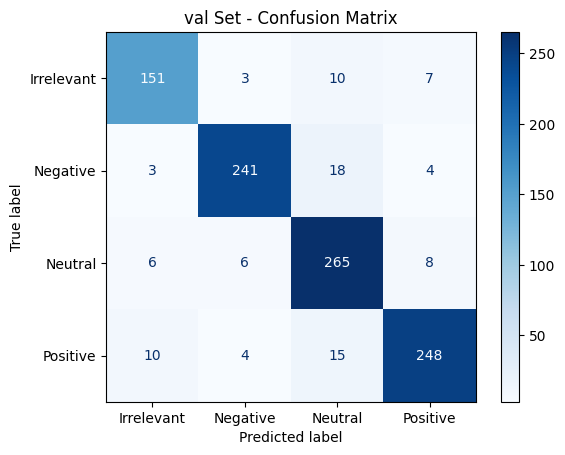

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

val_predictions = model.predict(val_dataset.batch(64))
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
val_predicted_sentiments = data_val['Sentiment_label'].cat.categories[val_predicted_labels]

# Convert the true labels to their original sentiment categories
val_true_labels = data_val['Sentiment_label']

# Get the unique labels/categories from the true labels
labels = np.unique(val_true_labels)


# Calculate the classification report for the val set
val_classification_rep = classification_report(val_true_labels, val_predicted_sentiments)
print("val Set - Classification Report:\n", val_classification_rep)

# Generate the confusion matrix for the val set
val_confusion_mat = confusion_matrix(val_true_labels, val_predicted_sentiments)

# Plot the confusion matrix for the val set
val_display = ConfusionMatrixDisplay(confusion_matrix=val_confusion_mat, display_labels=labels)
val_display.plot(cmap='Blues')
plt.title("val Set - Confusion Matrix")
plt.grid(False)
plt.show()

In [13]:
test_df = pd.read_csv('processed_test_df.csv')
test_df = test_df[['Entity', 'Content', 'Sentiment']]
test_df.columns = ['Entity', 'Content', 'Sentiment']
test_df

,Entity,Content,Sentiment
0,Amazon,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral
1,Microsoft,@Microsoft Why do I pay for WORD when it funct...,Negative
2,CS-GO,"CSGO matchmaking is so full of closet hacking,...",Negative
3,Google,Now the President is slapping Americans in the...,Neutral
4,FIFA,Hi @EAHelp I’ve had Madeleine McCann in my cel...,Negative
...,...,...,...
994,GrandTheftAuto(GTA),⭐️ Toronto is the arts and culture capital of ...,Irrelevant
995,CS-GO,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,Irrelevant
996,Borderlands,Today sucked so it’s time to drink wine n play...,Positive
997,Microsoft,Bought a fraction of Microsoft today. Small wins.,Positive


In [14]:
# Specify the file path
misclassified_file_path = 'misclassified_distilbert.txt'

# Find misclassified examples
misclassified_indices = np.where(val_predicted_labels != val_labels)[0]

# Write details of misclassified examples to a file
with open(misclassified_file_path, 'w', encoding='utf-8') as file:  # Specify UTF-8 encoding
    file.write("Misclassified Examples:\n")
    file.write("\n")

    for idx in misclassified_indices:
        true_label = val_true_labels.iloc[idx]
        predicted_label = val_predicted_sentiments[idx]
        content = test_df.loc[idx]['Content']
        file.write(f"Example {idx + 1} - True Label: {true_label}, Predicted Label: {predicted_label}\n")
        file.write(f"Content: {content}\n")
        file.write("\n")

print(f"Misclassified examples details have been written to: {misclassified_file_path}")


Misclassified examples details have been written to: misclassified_distilbert.txt
